In [1]:
#importing essential modules
import pandas as pd
import numpy as np
import os
from os import path
import time
from random import seed, choice

## Load Data from S3

>The below cells load test data from Sagemaker S3 storage

In [2]:
import boto3
import sagemaker

# S3 bucket to load
bucket = "sagemaker-eu-central-1-515611759963"

# session and role
sagemaker_session = sagemaker.Session(default_bucket=bucket)
role = sagemaker.get_execution_role()


prefix = "food-classifier"

model_space = "sagemaker-pytorch-2020-03-08-17-17-19-239"

model_data = 's3://{}/{}/{}/output/model.tar.gz'.format(bucket, prefix, model_space)
model_data

's3://sagemaker-eu-central-1-515611759963/food-classifier/sagemaker-pytorch-2020-03-08-17-17-19-239/output/model.tar.gz'

In [9]:
test_img_path = sagemaker_session.list_s3_files(bucket, prefix + "/test_img")[0]
test_img_path

'food-classifier/test_img/beef_carpaccio/100853.jpg'

In [12]:
test_imgs_path = 'test_img'
testfolder = 's3://{}/{}/{}'.format(bucket, prefix, test_imgs_path)
testfolder

's3://sagemaker-eu-central-1-515611759963/food-classifier/test_img'

In [20]:
test_item_path = test_img_path.split("/")[-2:]
test_item = testfolder + "/{}".format(test_item_path[0], test_item_path[1])
test_item

's3://sagemaker-eu-central-1-515611759963/food-classifier/test_img/beef_carpaccio'

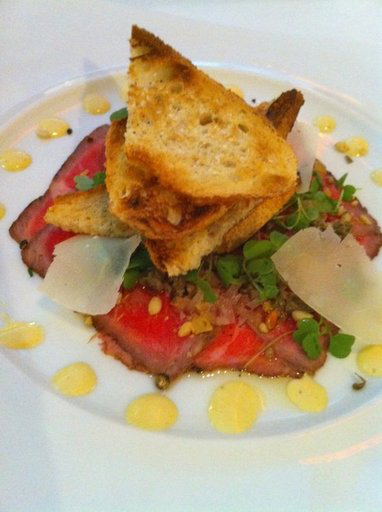

In [27]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
fileslist = fs.ls(testfolder)

# open it directly
with fs.open('s3://sagemaker-eu-central-1-515611759963/food-classifier/test_img/beef_carpaccio/100853.jpg') as f:
    
    imgtest = Image.open(f)
    
    display(imgtest)

> ## Deploy the model for testing

The model will be tested by first deploying it and then sending the testing data to the deployed endpoint

The function that loads the saved model is called `model_fn()` and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file specified as the entry point.

> ## Checking deploy.py

In [5]:
!pygmentize pytorch_source/deploy.py

import os
import pandas as pd
import numpy as np
import json

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data

from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# imports the model in model.py by name
from model import ResNetTransfer

from PIL import Image
import io

import pickle


def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using d

In [25]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImgPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='application/x-image', 
                                           deserializer = json_deserializer ,accept='application/json')

In [7]:
model_data = bucket +
model_data

'sagemaker-eu-central-1-515611759963'

In [25]:
# in case we want to retrieve the model from s3
estimator = PyTorchModel(model_data='s3://sagemaker-eu-central-1-515611759963/food-classifier/sagemaker-pytorch-2020-03-08-17-17-19-239/output/model.tar.gz', 
                             role=role,
                             source_dir='pytorch_source',
                             entry_point='deploy.py',
                            predictor_cls = ImgPredictor,
                           framework_version = '1.1.0')

In [26]:
predictor = estimator.deploy(instance_type='ml.p2.xlarge', initial_instance_count=1)

-----------------!

> ## Test with an image

In [29]:
from PIL import Image
image = Image.open(test_data.imgs[0][0]).convert('RGB')

In [30]:
test_img_path = test_data.imgs[0][0]

'../data/test_img/beef_carpaccio/100853.jpg'

In [31]:
class_to_foodname = dict(zip(list(test_data.class_to_idx.values()),list(test_data.class_to_idx.keys())))

{'beef_carpaccio': 0,
 'carrot_cake': 1,
 'escargots': 2,
 'ramen': 3,
 'strawberry_shortcake': 4}

In [32]:
with open(test_img_path, "rb") as image:
    f = image.read()
    b = bytearray(f)

255


In [33]:
a = predictor.predict(b)

In [36]:
class_to_foodname[int(a['class'])]

4.0